In [1]:
import random

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc


import uproot 
import awkward as ak
import pickle

In [2]:
file = "/home/dejavu/Projects/qgcal/Sample_Inspect/dijet_sample_flatten.npy"
all_jets = np.load(file)

In [3]:
filename = 'bdt_model.sav'
bdt = pickle.load(open(filename, 'rb'))

In [4]:
bdt

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=5,
                                                         max_features='auto',
                                                         min_samples_leaf=0.001),
                   learning_rate=0.5, n_estimators=600)

In [5]:
gluon_idx = np.where(all_jets[:,-2]==21)[0]
light_quark_idx = np.where((all_jets[:,-2]==1) | (all_jets[:,-2]==2)| (all_jets[:,-2]==3))[0]
gluon = all_jets[gluon_idx]
quark = all_jets[light_quark_idx]

In [6]:
event_start = 100000
nevents = 200000

X = np.concatenate((quark[event_start:event_start+nevents], gluon[event_start:event_start+nevents]), axis=0)
y = np.concatenate((np.zeros(nevents), 1.0 * np.ones(nevents)))

In [7]:
y_decisions = bdt.decision_function(X[:, :5])

In [8]:
def Draw_BDT_Score(X_test, y_test, y_test_decisions, title="New Training", save=False):
    y_test_gluon_id = np.where(y_test==1)[0]
    y_test_quark_id = np.where(y_test==0)[0]

    fpr, tpr, thresholds = roc_curve(y_test, y_test_decisions, sample_weight = X_test[:,-1])
    roc_auc = auc(fpr, tpr)
    bins_scores = np.linspace(-1, 1, 50)
    plt.hist(y_test_decisions[y_test_gluon_id], weights=X_test[y_test_gluon_id][:, -1], bins= bins_scores, alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'blue') 
    plt.hist(y_test_decisions[y_test_quark_id], weights=X_test[y_test_quark_id][:, -1], bins= bins_scores, alpha=0.5, label='quark'+f"_num: {len(y_test_quark_id)}", color = 'red')
    plt.legend(loc='upper left')
    plt.text(0.05, 0.75, f"num: {len(X_test)}", transform=plt.gca().transAxes)
    plt.text(0.75, 0.85, f"roc: {roc_auc:.4f}", transform=plt.gca().transAxes)
    plt.xlabel("BDT Decision Function")
    plt.ylabel("number of jets")
    plt.title(title)
    if save:
        plt.savefig(title.replace(" ", "_"))
    plt.show()


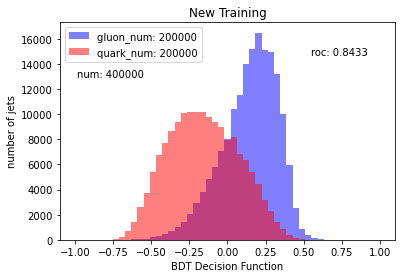

In [9]:
Draw_BDT_Score(X, y, y_decisions, save=True)

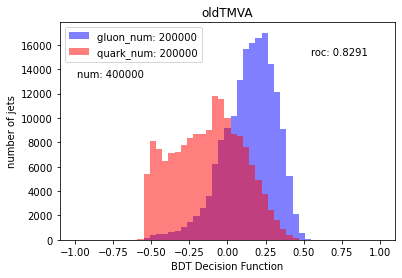

In [10]:
Draw_BDT_Score(X, y, X[:,-3], title="oldTMVA", save=True)

In [11]:
y_decisions_all = bdt.decision_function(all_jets[:, :5])

In [12]:
y_decisions_all.shape

(72778406,)

In [14]:
all_jets.shape

(72778406, 8)

In [15]:
all_jet_newBDT = np.concatenate((all_jets, y_decisions_all[:, None]), axis=1)

In [16]:
all_jet_newBDT.shape

(72778406, 9)

In [17]:
np.save("dijet_sample_newBDT_flatten.npy",all_jet_newBDT)

In [19]:
!ls -alh dijet_sample_newBDT_flatten.npy

-rw-r--r-- 1 dejavu dejavu 4.9G Aug 16 17:43 dijet_sample_newBDT_flatten.npy
